In [ ]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/Colab Notebooks/nlp_assignments/a1" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 1> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

In [ ]:

# Basic dependencies
import argparse
import logging
import os
import os.path as osp
import random
import shutil
import sys
import time
import itertools
import regex as re
from collections import Counter

import numpy as np
import pandas as pd
import sklearn.metrics as evaluator

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer as PS
from nltk.stem.snowball import SnowballStemmer as SS
from nltk.stem import WordNetLemmatizer as WNL

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import BernoulliNB as BNB
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.svm import LinearSVC as SVM

from sklearn.model_selection import GridSearchCV as GS

import matplotlib.pyplot as plt

In [ ]:
train_dataset = '/content/assignment/train_dataset.csv'
test_dataset = '/content/assignment/test_dataset.csv'

In [ ]:
train = pd.read_csv(train_dataset, delimiter=',')
test = pd.read_csv(test_dataset, delimiter=',')

In [ ]:
print(train.shape)
print(test.shape)

(960, 3)
(240, 3)


In [ ]:
print(train.columns)
print(test.columns)

Index(['animal_name', 'animal_description', 'label'], dtype='object')
Index(['animal_name', 'animal_description', 'label'], dtype='object')


In [ ]:
combined_df = pd.concat([train, test], ignore_index=True)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(combined_df, test_size=0.2, stratify=combined_df[['animal_name', 'label']])

In [ ]:
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [ ]:
print(train_df.columns)
print(test_df.columns)

Index(['index', 'animal_name', 'animal_description', 'label'], dtype='object')
Index(['index', 'animal_name', 'animal_description', 'label'], dtype='object')


In [ ]:
print(train_df.shape)
print(test_df.shape)

(960, 4)
(240, 4)


In [ ]:
x_train = train_df.drop('label', axis=1)
y_train = train_df['label']

In [ ]:
print(len(x_train))

960


In [ ]:
x_train.index

RangeIndex(start=0, stop=960, step=1)

In [ ]:
# pre-processing
nltk.download('stopwords')
ps = PS()
corpus = []
for i in range(0, len(x_train)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_train['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [ps.stem(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  corpus.append(description)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(len(corpus))

960


In [ ]:
corpus[9]

'duck annual talent show call duck got talent'

In [ ]:
# Appling Bag of Words, CountVectorizer
cv = CountVectorizer()
x = cv.fit_transform(corpus).toarray()

In [ ]:
x.shape

(960, 1874)

In [ ]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
classifier=MNB()

In [ ]:
classifier.fit(x, y_train)

MultinomialNB()

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
# pre-processing
nltk.download('stopwords')
ps = PS()
test_corpus = []
for i in range(0, len(x_test)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_test['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [ps.stem(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  test_corpus.append(description)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
x_test = cv.transform(test_corpus).toarray()

In [ ]:
x_test.shape

(240, 1874)

In [ ]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [ ]:
pred = classifier.predict(x_test)

accuracy:   0.938
Confusion matrix, without normalization


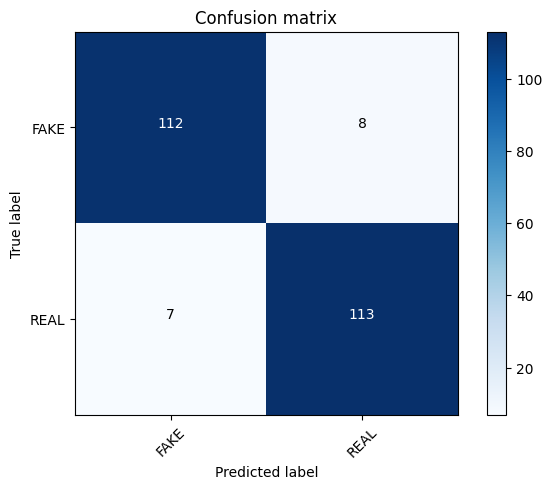

In [ ]:
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
binomial_classifier=BNB()

In [ ]:
binomial_classifier.fit(x, y_train)

BernoulliNB()

In [ ]:
pred = binomial_classifier.predict(x_test)

accuracy:   0.929
Confusion matrix, without normalization


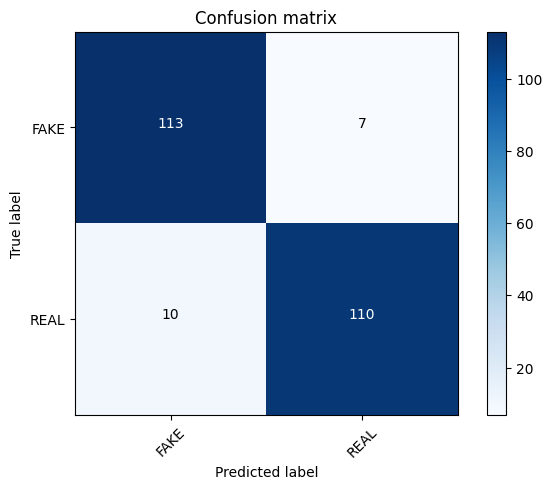

In [ ]:
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
lr_classifier = LR()

In [ ]:
lr_classifier.fit(x, y_train)

LogisticRegression()

In [ ]:
pred = lr_classifier.predict(x_test)

accuracy:   0.950
Confusion matrix, without normalization


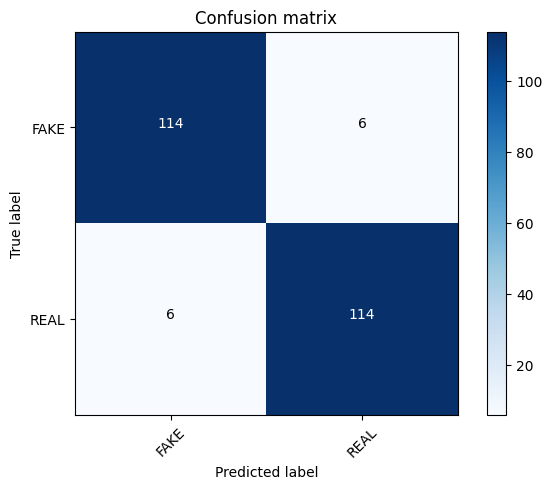

In [ ]:
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
svm_classifier = SVM()
svm_classifier.fit(x, y_train)

LinearSVC()

In [ ]:
pred = svm_classifier.predict(x_test)

accuracy:   0.929
Confusion matrix, without normalization


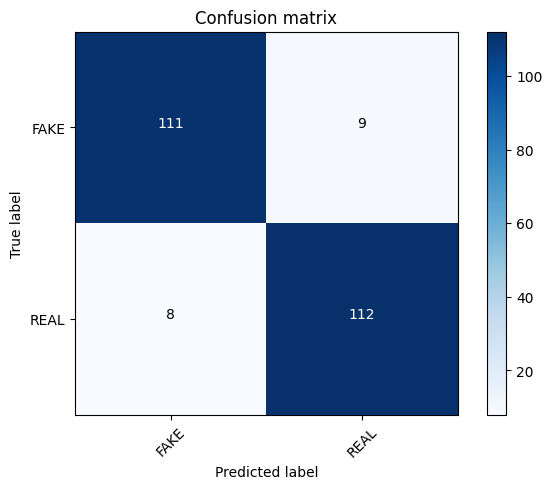

In [ ]:
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# pre-processing
nltk.download('stopwords')
ss = SS("english")
corpus = []
for i in range(0, len(x_train)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_train['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [ss.stem(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  corpus.append(description)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Appling Bag of Words, CountVectorizer
cv = CountVectorizer()
x = cv.fit_transform(corpus).toarray()

In [ ]:
classifier=MNB()
classifier.fit(x, y_train)
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
# pre-processing
nltk.download('stopwords')
ss = SS("english")
test_corpus = []
for i in range(0, len(x_test)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_test['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [ps.stem(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  test_corpus.append(description)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
x_test = cv.transform(test_corpus).toarray()
x_test.shape

(240, 1863)

In [ ]:
pred = classifier.predict(x_test)

accuracy:   0.933
Confusion matrix, without normalization


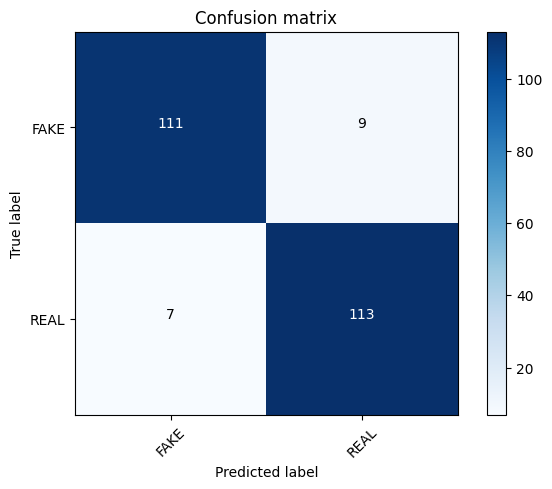

In [ ]:
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
x.shape

(960, 1863)

In [ ]:
x_test.shape

(240, 1863)

accuracy:   0.929
Confusion matrix, without normalization


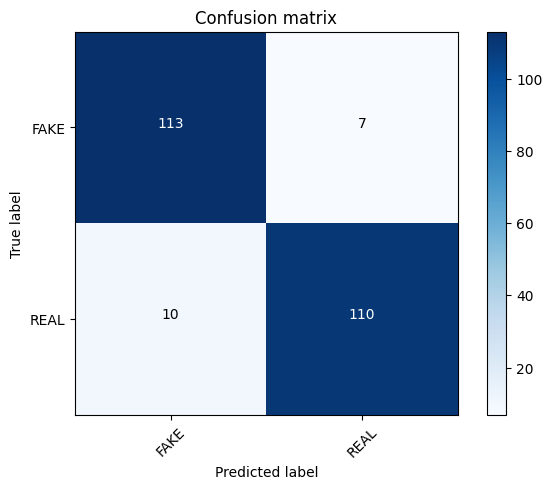

In [ ]:
binomial_classifier=BNB()
binomial_classifier.fit(x, y_train)
pred = binomial_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.938
Confusion matrix, without normalization


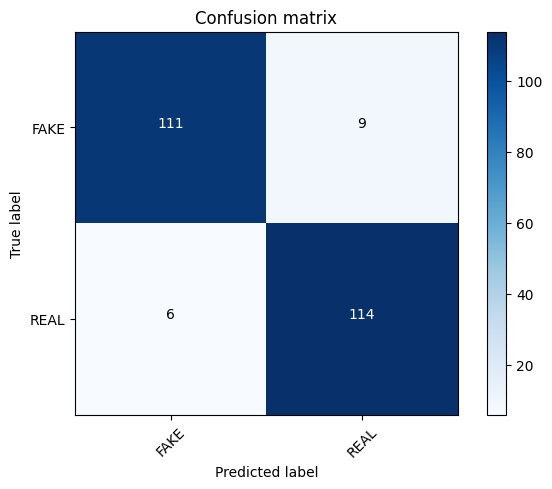

In [ ]:
lr_classifier = LR()
lr_classifier.fit(x, y_train)
pred = lr_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.917
Confusion matrix, without normalization


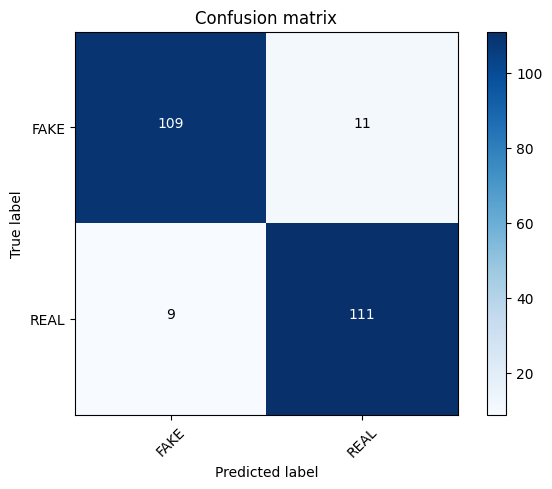

In [ ]:
svm_classifier = SVM()
svm_classifier.fit(x, y_train)
pred = svm_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
wnl = WNL()
# sentences = nltk.sent_tokenize(x_train)
corpus = []
for i in range(0, len(x_train)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_train['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [wnl.lemmatize(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  corpus.append(description)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Appling Bag of Words, CountVectorizer
cv = CountVectorizer()
x = cv.fit_transform(corpus).toarray()

In [ ]:
x.shape

(960, 2127)

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
wnl = WNL()
test_corpus = []
for i in range(0, len(x_test)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_test['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [wnl.lemmatize(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  test_corpus.append(description)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
x_test = cv.transform(test_corpus).toarray()
x_test.shape

(240, 2127)

accuracy:   0.933
Confusion matrix, without normalization


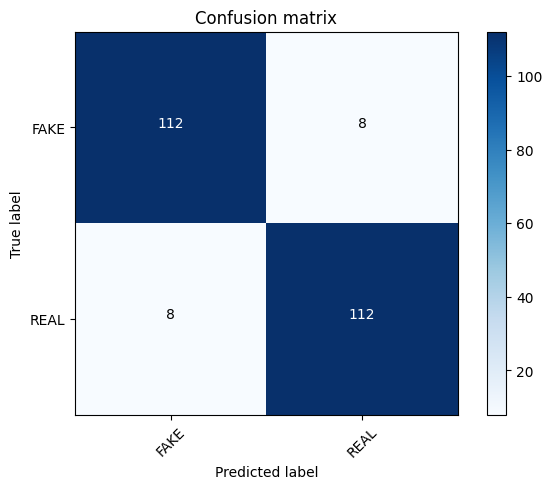

In [ ]:
classifier=MNB()
classifier.fit(x, y_train)
pred = classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.933
Confusion matrix, without normalization


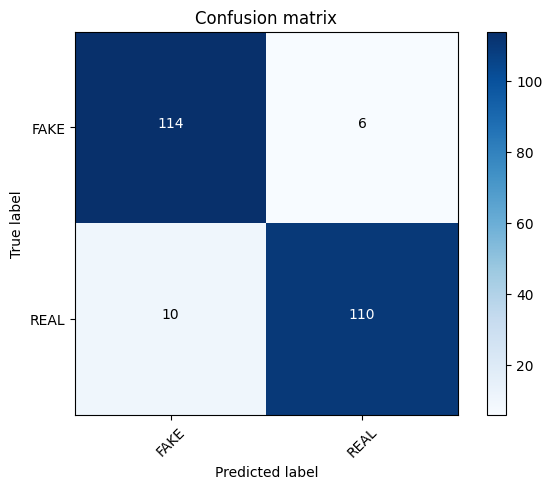

In [ ]:
binomial_classifier=BNB()
binomial_classifier.fit(x, y_train)
pred = binomial_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.938
Confusion matrix, without normalization


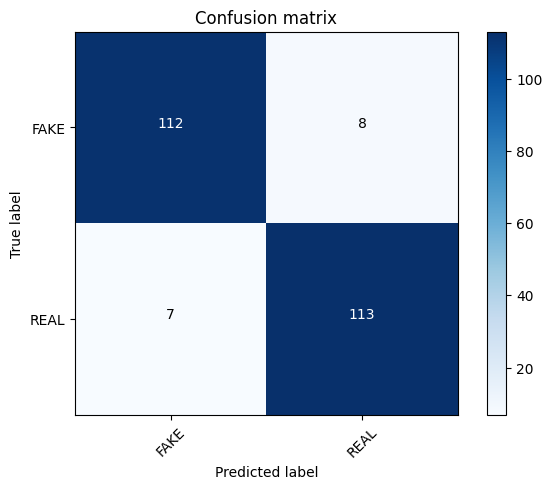

In [ ]:
lr_classifier = LR()
lr_classifier.fit(x, y_train)
pred = lr_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.929
Confusion matrix, without normalization


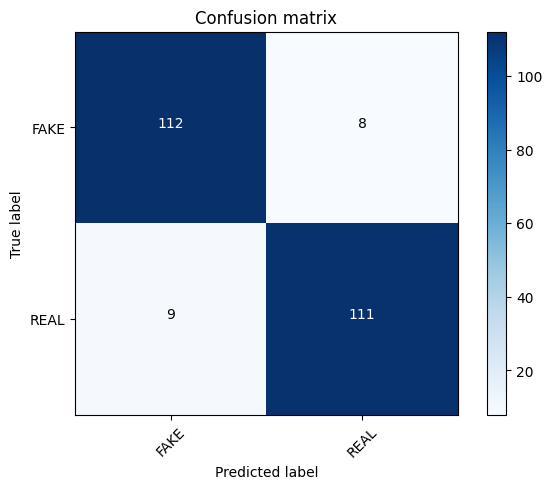

In [ ]:
svm_classifier = SVM()
svm_classifier.fit(x, y_train)
pred = svm_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# pre-processing
nltk.download('stopwords')
ps = PS()
corpus = []
for i in range(0, len(x_train)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_train['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [ps.stem(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  corpus.append(description)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Applying TfidfVectorizer
cv=TfidfVectorizer()
x = cv.fit_transform(corpus).toarray()

In [ ]:
x.shape

(960, 1874)

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
# pre-processing
nltk.download('stopwords')
ps = PS()
test_corpus = []
for i in range(0, len(x_test)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_test['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [ps.stem(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  test_corpus.append(description)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
x_test = cv.transform(test_corpus).toarray()

In [ ]:
x_test.shape

(240, 1874)

accuracy:   0.938
Confusion matrix, without normalization


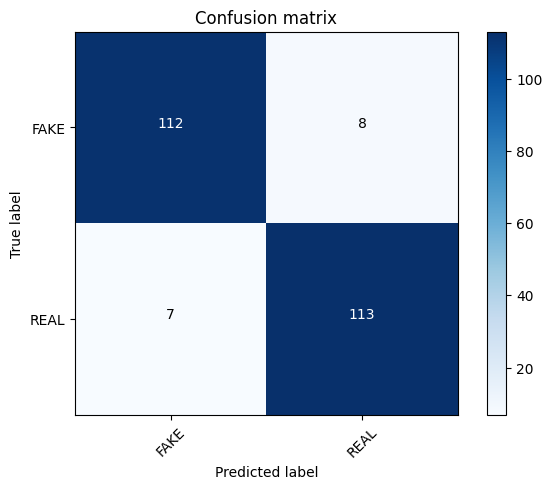

In [ ]:
classifier=MNB()
classifier.fit(x, y_train)
pred = classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.929
Confusion matrix, without normalization


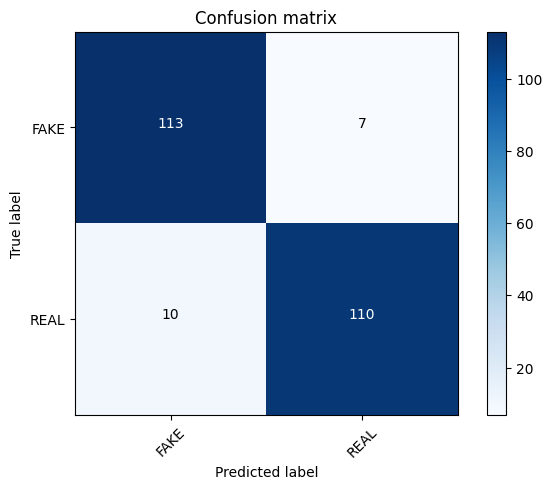

In [ ]:
binomial_classifier=BNB()
binomial_classifier.fit(x, y_train)
pred = binomial_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.938
Confusion matrix, without normalization


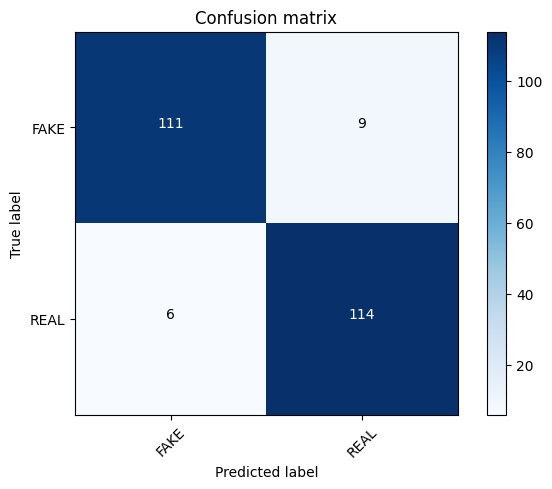

In [ ]:
lr_classifier = LR()
lr_classifier.fit(x, y_train)
pred = lr_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.946
Confusion matrix, without normalization


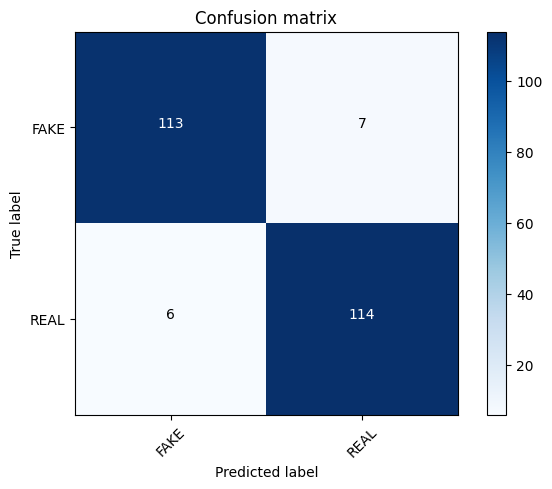

In [ ]:
svm_classifier = SVM()
svm_classifier.fit(x, y_train)
pred = svm_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# pre-processing
nltk.download('stopwords')
ss = SS("english")
corpus = []
for i in range(0, len(x_train)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_train['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [ss.stem(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  corpus.append(description)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Appling TfidfVectorizer
cv = TfidfVectorizer()
x = cv.fit_transform(corpus).toarray()

In [ ]:
x.shape

(960, 1863)

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
# pre-processing
nltk.download('stopwords')
ss = SS("english")
test_corpus = []
for i in range(0, len(x_test)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_test['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [ps.stem(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  test_corpus.append(description)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
x_test = cv.transform(test_corpus).toarray()
x_test.shape

(240, 1863)

accuracy:   0.933
Confusion matrix, without normalization


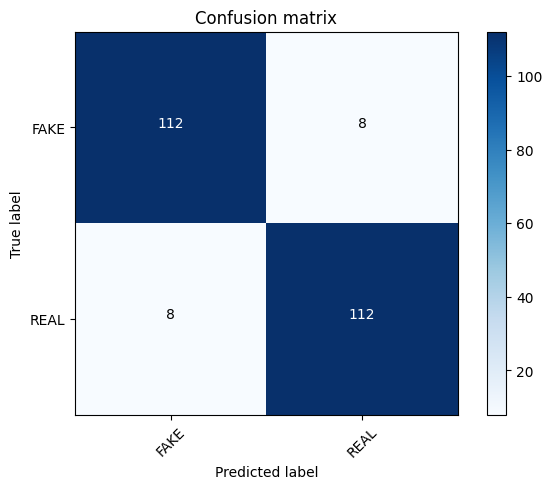

In [ ]:
classifier=MNB()
classifier.fit(x, y_train)
pred = classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.929
Confusion matrix, without normalization


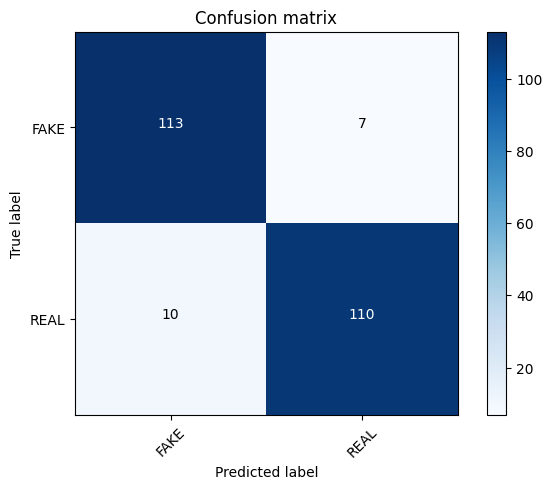

In [ ]:
binomial_classifier=BNB()
binomial_classifier.fit(x, y_train)
pred = binomial_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.929
Confusion matrix, without normalization


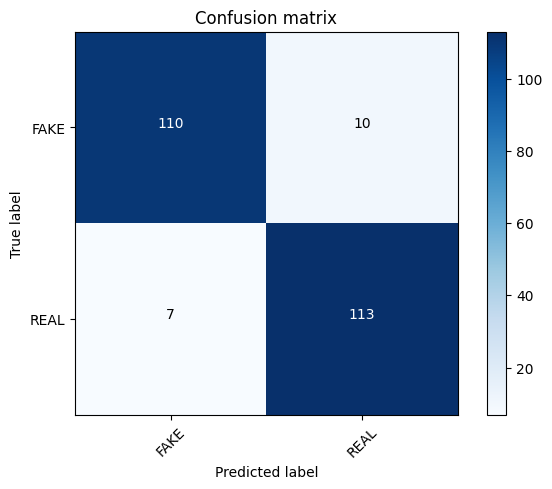

In [ ]:
lr_classifier = LR()
lr_classifier.fit(x, y_train)
pred = lr_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.933
Confusion matrix, without normalization


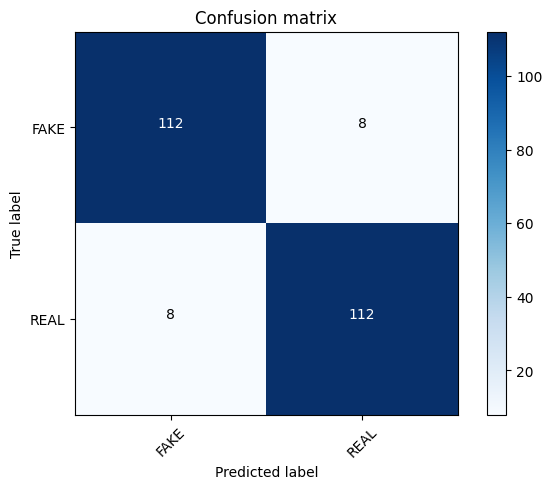

In [ ]:
svm_classifier = SVM()
svm_classifier.fit(x, y_train)
pred = svm_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
wnl = WNL()
# sentences = nltk.sent_tokenize(x_train)
corpus = []
for i in range(0, len(x_train)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_train['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [wnl.lemmatize(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  corpus.append(description)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Applying TfIdf
cv = TfidfVectorizer()
x = cv.fit_transform(corpus).toarray()

In [ ]:
x.shape

(960, 2127)

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
wnl = WNL()
test_corpus = []
for i in range(0, len(x_test)):
  # remove puntuation
  description = re.sub('[^a-zA-Z]', ' ', x_test['animal_description'][i])
  # convert into lower
  description = description.lower()
  # split based on spaces
  description = description.split()

  # remove stop words
  description = [wnl.lemmatize(word) for word in description if not word in stopwords.words('english')]
  description = ' '.join(description)
  test_corpus.append(description)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
x_test = cv.transform(test_corpus).toarray()
x_test.shape

(240, 2127)

accuracy:   0.933
Confusion matrix, without normalization


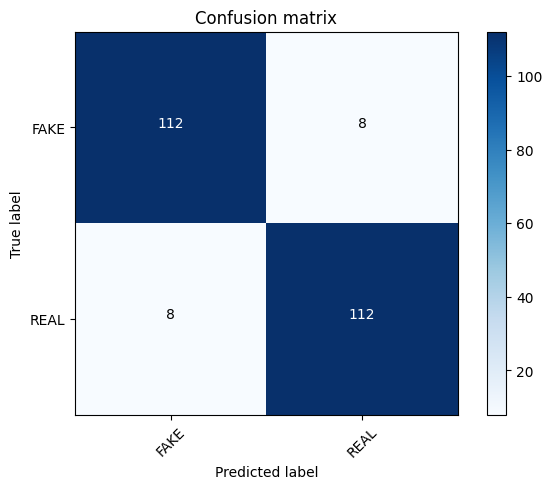

In [ ]:
classifier=MNB()
classifier.fit(x, y_train)
pred = classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.933
Confusion matrix, without normalization


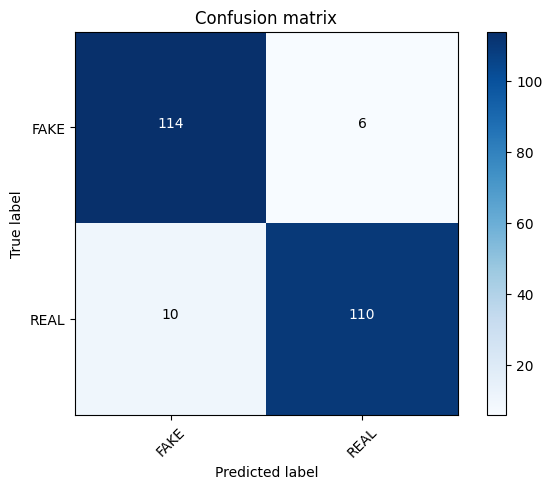

In [ ]:
binomial_classifier=BNB()
binomial_classifier.fit(x, y_train)
pred = binomial_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.921
Confusion matrix, without normalization


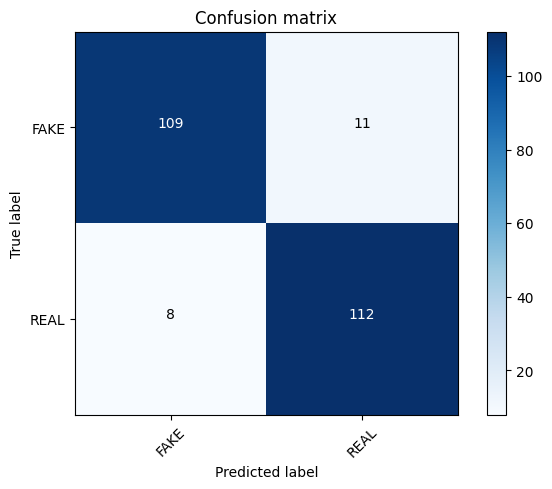

In [ ]:
lr_classifier = LR()
lr_classifier.fit(x, y_train)
pred = lr_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.938
Confusion matrix, without normalization


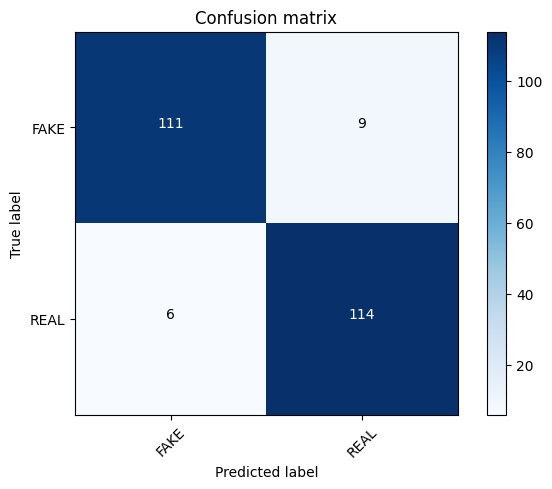

In [ ]:
svm_classifier = SVM()
svm_classifier.fit(x, y_train)
pred = svm_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
type(x_train['animal_description'].values.tolist())

list

In [ ]:
x_train['animal_description'].values.tolist()[:2]

['Bumblebees are a type of flying insect known for their distinctive black and yellow striped bodies.',
 'Bumblebees belong to the genus Bombus and are part of the Apidae family, which also includes honey bees.']

In [ ]:
# Applying TfIdf
cv = TfidfVectorizer(lowercase=False)
x = cv.fit_transform(x_train['animal_description'].values.tolist()).toarray()

In [ ]:
x.shape

(960, 2510)

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
x_test = cv.transform(test_corpus).toarray()
x_test.shape

(240, 2510)

accuracy:   0.896
Confusion matrix, without normalization


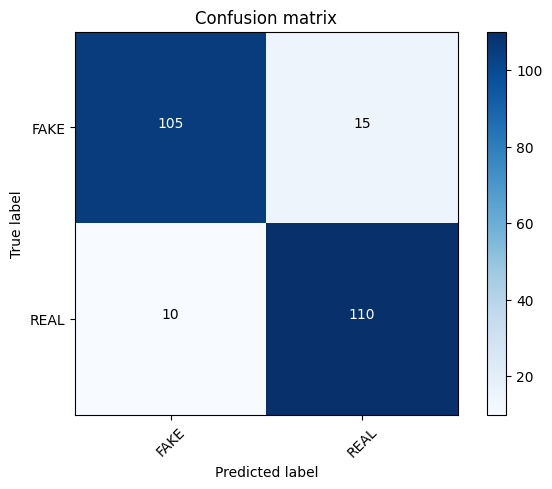

In [ ]:
classifier=MNB()
classifier.fit(x, y_train)
pred = classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.887
Confusion matrix, without normalization


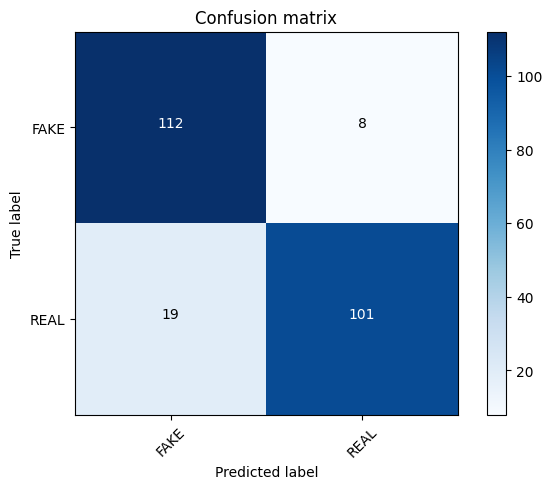

In [ ]:
binomial_classifier=BNB()
binomial_classifier.fit(x, y_train)
pred = binomial_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.858
Confusion matrix, without normalization


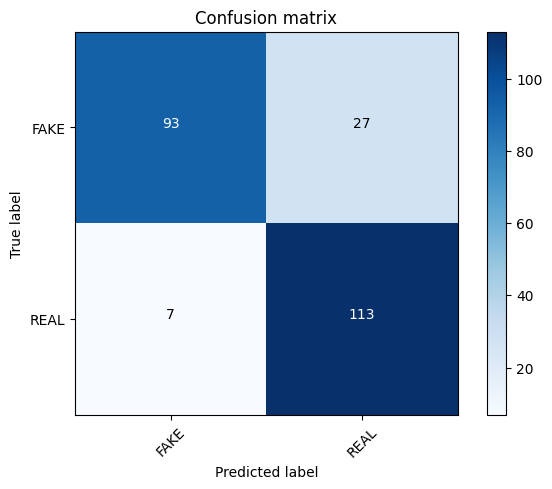

In [ ]:
lr_classifier = LR()
lr_classifier.fit(x, y_train)
pred = lr_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.875
Confusion matrix, without normalization


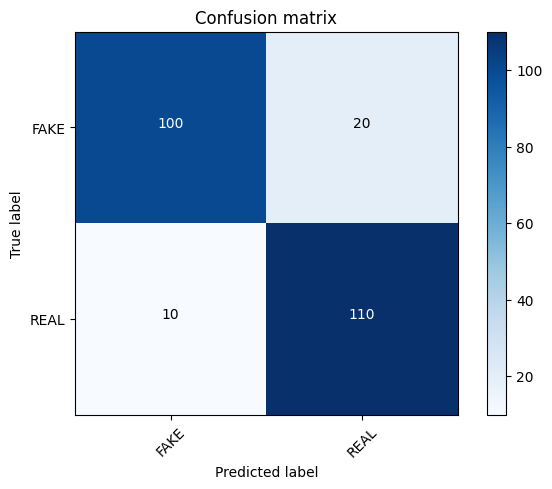

In [ ]:
svm_classifier = SVM()
svm_classifier.fit(x, y_train)
pred = svm_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# Applying Bag-of-words
cv = CountVectorizer(lowercase=False)
x = cv.fit_transform(x_train['animal_description'].values.tolist()).toarray()

In [ ]:
x.shape

(960, 2510)

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
x_test = cv.transform(test_corpus).toarray()
x_test.shape

(240, 2510)

accuracy:   0.892
Confusion matrix, without normalization


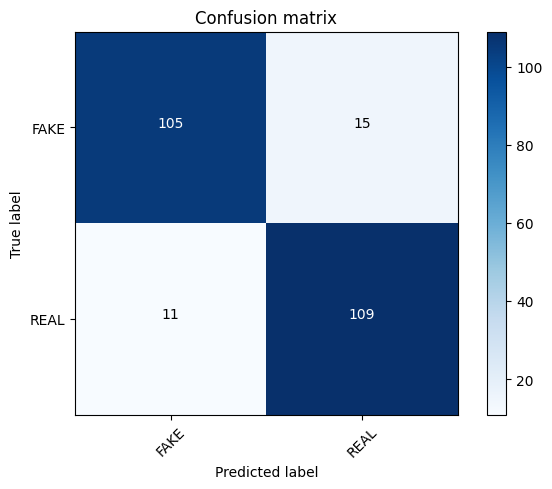

In [ ]:
classifier=MNB()
classifier.fit(x, y_train)
pred = classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.887
Confusion matrix, without normalization


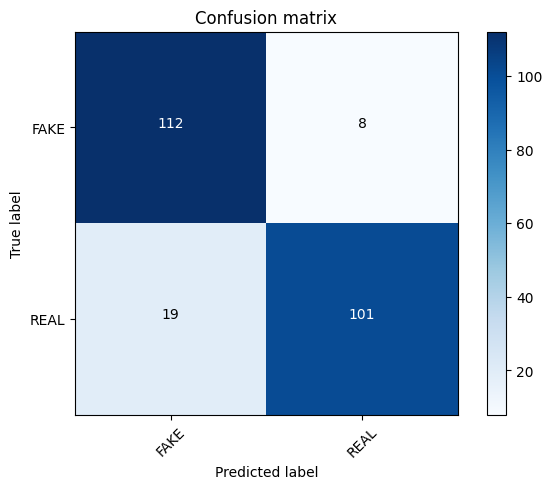

In [ ]:
binomial_classifier=BNB()
binomial_classifier.fit(x, y_train)
pred = binomial_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.850
Confusion matrix, without normalization


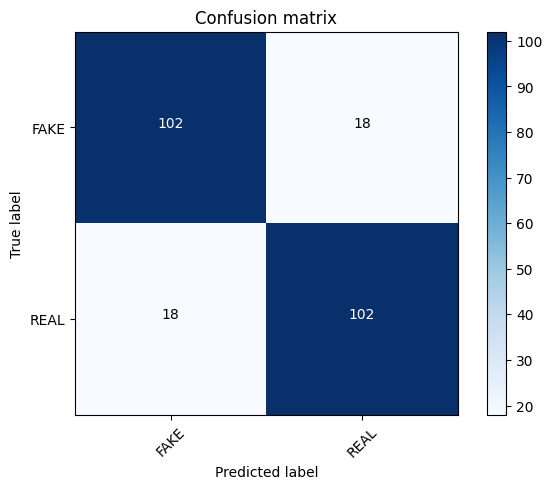

In [ ]:
lr_classifier = LR()
lr_classifier.fit(x, y_train)
pred = lr_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.842
Confusion matrix, without normalization


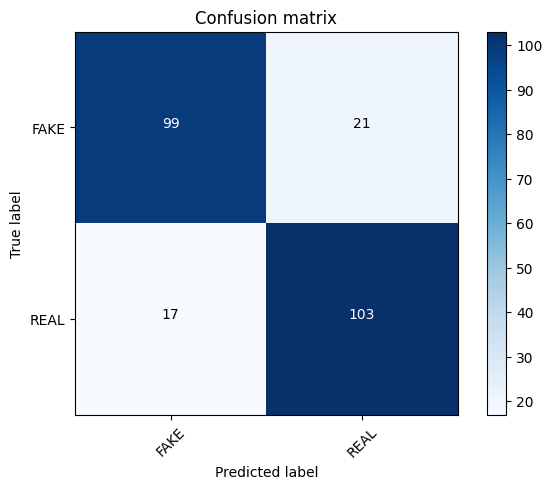

In [ ]:
svm_classifier = SVM()
svm_classifier.fit(x, y_train)
pred = svm_classifier.predict(x_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MNB()),
                     ])

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
text_clf = text_clf.fit(x_train['animal_description'], y_train)

In [ ]:
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.942
Confusion matrix, without normalization


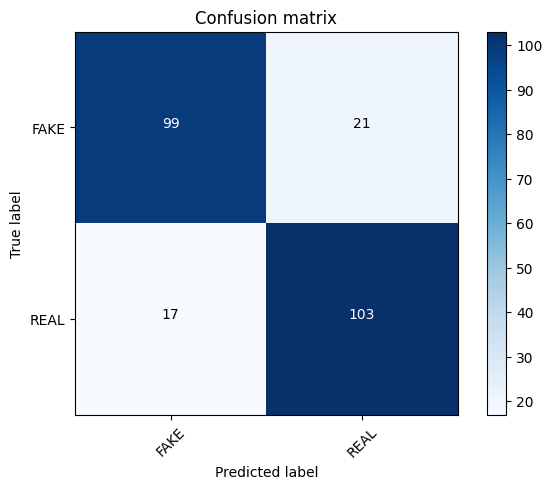

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', BNB()),
                     ])

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']
text_clf = text_clf.fit(x_train['animal_description'], y_train)
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.942
Confusion matrix, without normalization


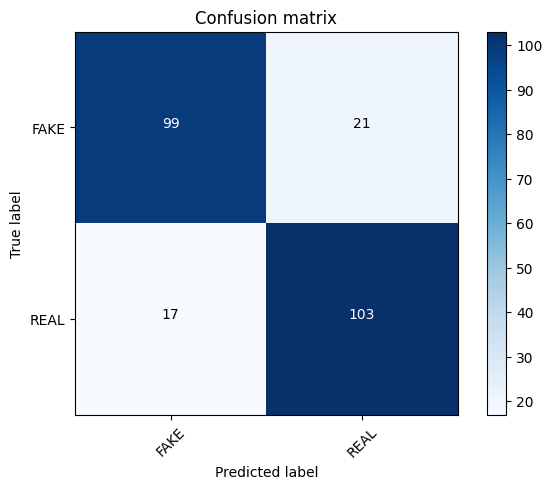

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', LR()),
                     ])

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']
text_clf = text_clf.fit(x_train['animal_description'], y_train)
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.933
Confusion matrix, without normalization


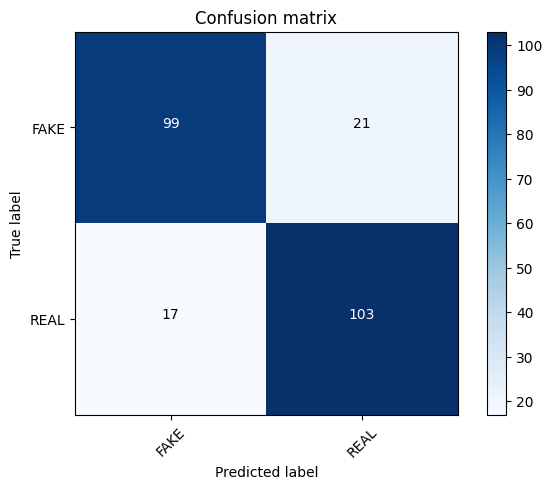

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SVM()),
                     ])

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']
text_clf = text_clf.fit(x_train['animal_description'], y_train)
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.938
Confusion matrix, without normalization


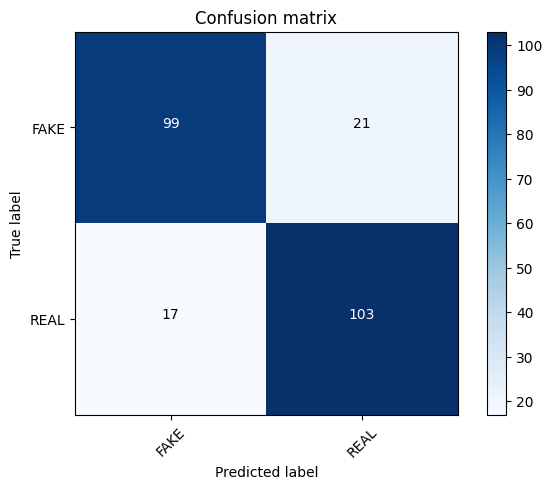

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MNB()),
                     ])

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']
text_clf = text_clf.fit(x_train['animal_description'], y_train)
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.942
Confusion matrix, without normalization


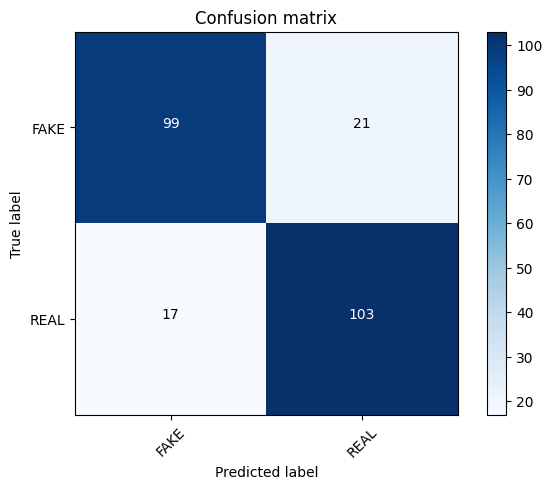

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', BNB()),
                     ])

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']
text_clf = text_clf.fit(x_train['animal_description'], y_train)
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.933
Confusion matrix, without normalization


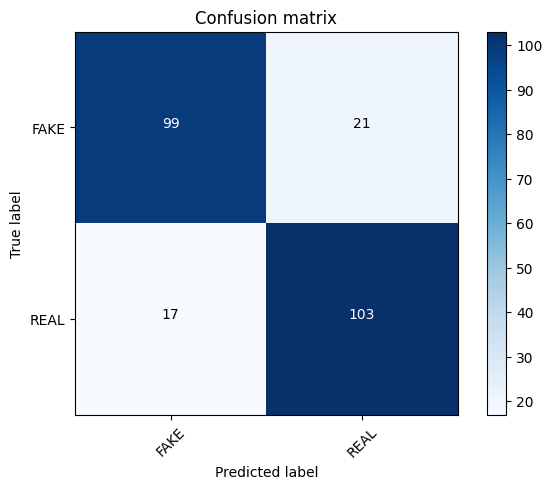

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', LR()),
                     ])

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']
text_clf = text_clf.fit(x_train['animal_description'], y_train)
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.933
Confusion matrix, without normalization


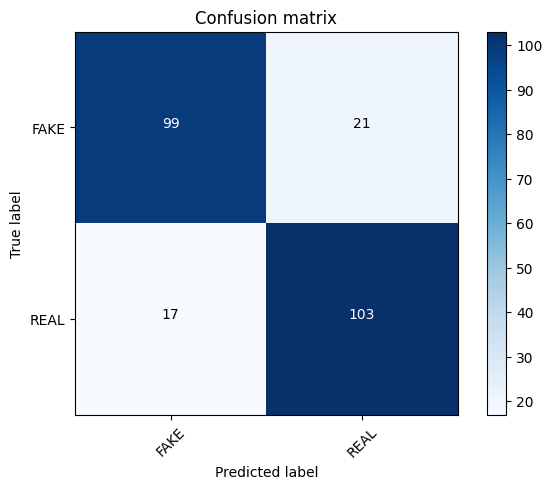

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SVM()),
                     ])

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']
text_clf = text_clf.fit(x_train['animal_description'], y_train)
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.933
Confusion matrix, without normalization


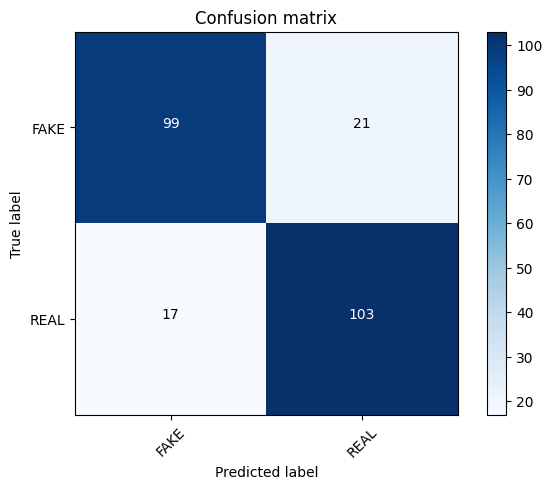

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MNB()),
                     ])

In [ ]:
# Grid Search CV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__stop_words': (None, 'english'),
              'vect__lowercase': (True, False),
              'tfidf__use_idf': (True, False),
              'tfidf__norm': ('l1', 'l2'),
              'clf__alpha': (1, 1e-1, 1e-2, 1e-3),}

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
gs_clf = GS(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(x_train['animal_description'], y_train)

In [ ]:
gs_clf.best_score_

0.9645833333333333

In [ ]:
gs_clf.best_params_

{'clf__alpha': 0.01,
 'tfidf__norm': 'l1',
 'tfidf__use_idf': True,
 'vect__lowercase': True,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': None}

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(lowercase=True, ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(norm='l2', use_idf=True)),
                      ('clf', MNB(alpha=0.01)),
                     ])

In [ ]:
text_clf = text_clf.fit(x_train['animal_description'], y_train)
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.938
Confusion matrix, without normalization


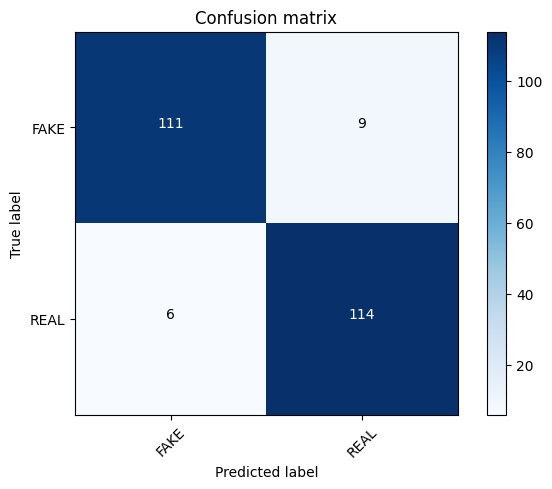

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, predicted)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', BNB()),
                     ])

In [ ]:
# Grid Search CV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__stop_words': (None, 'english'),
              'vect__lowercase': (True, False),
              'tfidf__use_idf': (True, False),
              'tfidf__norm': ('l1', 'l2'),
              'clf__alpha': (1, 1e-1, 1e-2, 1e-3),}

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
gs_clf = GS(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(x_train['animal_description'], y_train)

In [ ]:
gs_clf.best_score_

0.95625

In [ ]:
gs_clf.best_params_

{'clf__alpha': 0.01,
 'tfidf__norm': 'l1',
 'tfidf__use_idf': True,
 'vect__lowercase': True,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(lowercase=True, ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(norm='l1')),
                      ('clf', BNB(alpha=0.01)),
                     ])

In [ ]:
text_clf = text_clf.fit(x_train['animal_description'], y_train)
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.946
Confusion matrix, without normalization


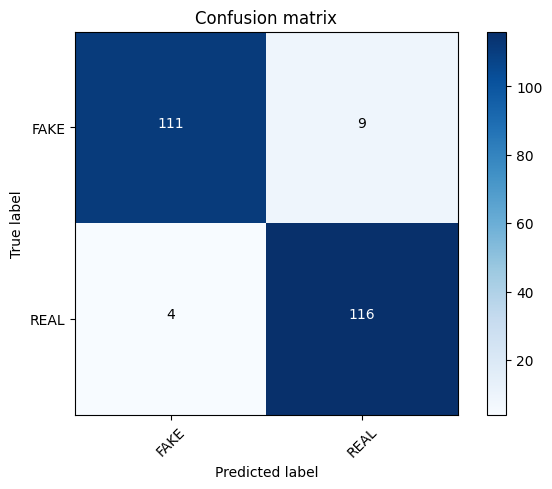

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, predicted)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
ps = PS()
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([ps.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', stemmed_count_vect),
                      ('tfidf', TfidfTransformer()),
                      ('clf', LR()),
                     ])

In [ ]:
# Grid Search CV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__stop_words': (None, 'english'),
              'vect__lowercase': (True, False),
              'tfidf__use_idf': (True, False),
              'tfidf__norm': ('l1', 'l2'),
              'clf__C': (10, 5, 2, 1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01),
              'clf__max_iter': (100, 300),}

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
gs_clf = GS(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(x_train['animal_description'], y_train)

In [ ]:
gs_clf.best_score_

0.9479166666666666

In [ ]:
gs_clf.best_params_

{'clf__C': 10,
 'clf__max_iter': 100,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': True,
 'vect__lowercase': True,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [ ]:
stemmed_count_grid_vect = StemmedCountVectorizer(stop_words=None, ngram_range=(1,2))

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', stemmed_count_grid_vect),
                      ('tfidf', TfidfTransformer(norm='l2')),
                      ('clf', LR(C=10)),
                     ])

In [ ]:
text_clf = text_clf.fit(x_train['animal_description'], y_train)
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.958
Confusion matrix, without normalization


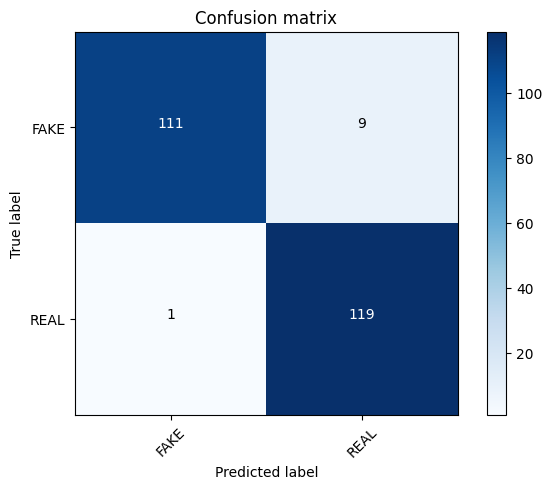

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, predicted)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
ps = PS()
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([ps.stem(w) for w in analyzer(doc)])
stemmed_tfidf_vect = StemmedTfidfVectorizer(stop_words='english')

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', stemmed_tfidf_vect),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SVM()),
                     ])

In [ ]:
# Grid Search CV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__stop_words': (None, 'english'),
              'vect__lowercase': (True, False),
              'tfidf__use_idf': (True, False),
              'tfidf__norm': ('l1', 'l2'),
              'clf__loss': ('hinge', 'squared_hinge'),
              'clf__C': (10, 5, 2, 1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01),}

In [ ]:
x_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [ ]:
gs_clf = GS(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(x_train['animal_description'], y_train)

In [ ]:
gs_clf.best_score_

0.9604166666666666

In [ ]:
gs_clf.best_params_

{'clf__C': 2,
 'clf__loss': 'squared_hinge',
 'tfidf__norm': 'l2',
 'tfidf__use_idf': True,
 'vect__lowercase': True,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [ ]:
stemmed_tfidf_grid_vect = StemmedTfidfVectorizer(ngram_range=(1,2))

In [ ]:
# Use TfIdfvectorizer equivalence= Bag-of-words+normalization(TfIdfTransformer)
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', stemmed_tfidf_grid_vect),
                      ('tfidf', TfidfTransformer(norm='l2', use_idf=True)),
                      ('clf', SVM(C=2, loss='squared_hinge')),
                     ])

In [ ]:
text_clf = text_clf.fit(x_train['animal_description'], y_train)
predicted = text_clf.predict(x_test['animal_description'])

accuracy:   0.963
Confusion matrix, without normalization


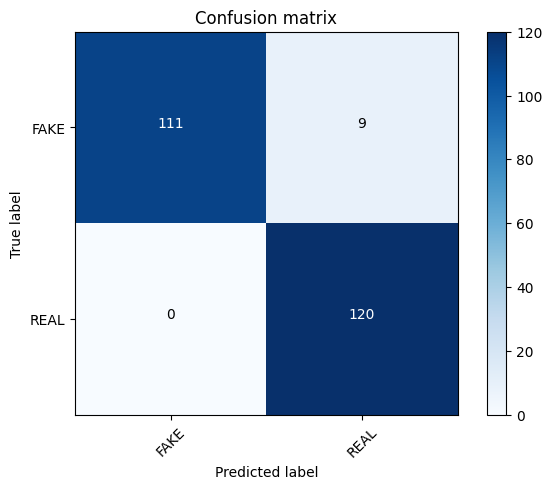

In [ ]:
score = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, predicted)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])